#  Increasing Bias Vs. Increasing Sample Size in Training Data

To analyze the effect of training data diversity
on prediction accuracy, the following experiments
were designed. First, MLP S-S models for sample
source prediction were trained with an increasing
number of unique SRA studies in the training data,
systematically increasing bias diversity. Only SRA
studies containing > 100 samples for either class were
considered. In order to control for training set size,
each SRA study was subsampled to 50 samples before
training. Six iterations of this training process were
conducted, starting with one study (i.e. one bias) per
class (biopsy vs. cell line). At each step one additional
SRA study per class was subsampled ending with six
SRA biases and 350 samples in the training set per
class. As a control experiment, we chose the largest
SRA study available for each class to create a training
set with a single bias per class. Starting with 50
samples per class in six iterations, we subsampled
an additional 50 samples ending with 350 samples,
thereby assessing the eect on performance that can
be attributed to the dataset size. Subsampling and
random selection of SRA studies were repeated 10
times with different seeds and each configuration was
trained on 10 different seeds, yielding an estimate of
uncertainty.

In [3]:
import pandas as pd
from sup_src import utility
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import tensorflow as tf

Load data

In [2]:
df_sra_train = pd.read_csv('data/sra_train_sample_source.csv', index_col='run_accession')
df_sra_test = pd.read_csv('data/sra_test_sample_source.csv', index_col='run_accession')
df_meta = pd.read_csv('data/meta.csv')

Annotate all samples with their their study accession. This is needed to split the data study wise. 

In [ ]:
df_sra_train = utility.label_sra_data(df_sra_train, df_meta, 'study_accession')

- select tissue and cell line only
- determine studies that have at least 100 samples 

In [ ]:
#get studies with n > 100
srp_t = df_sra_train.loc[df_sra_train.sample_type == 'TISSUE'].study_accession.unique()
srp_cl = df_sra_train.loc[df_sra_train.sample_type == 'CELL LINE'].study_accession.unique()
df_tissue = df_sra_train.loc[df_sra_train.study_accession.isin(srp_t)]
df_cell_line = df_sra_train.loc[df_sra_train.study_accession.isin(srp_cl)]

df_grouped_t = df_tissue.groupby('study_accession').count().sort_values('sample_type',ascending=False)
larger_100_t = df_grouped_t.loc[df_grouped_t.sample_type > 100].index.to_list()

df_grouped_cl = df_cell_line.groupby('study_accession').count().sort_values('sample_type',ascending=False)
larger_100_cl = df_grouped_cl.loc[df_grouped_cl.sample_type > 100].index.to_list()

## Increase number of biases (figure 4A)
- the j index is for the number of random samplings
- randomly sample 50 data points from each study selected above
- randomly sample 1 to 7 studies for the training set of each class
- train model / run experiment as described in **phenotype_prediction.ipynb**

In [ ]:
step_size = 50
for j in range(3):
    df_train_sub = pd.DataFrame()

    for each in larger_100_t+larger_100_cl:
        #sample 50 datapoints form each study with n > 100
        df_sub = df_sra_train.loc[df_sra_train.study_accession == each].sample(step_size)
        df_train_sub = pd.concat([df_train_sub, df_sub],axis=0)
        
    srp_train = df_train_sub.study_accession.unique()

    for i in range(1,7):
        rn_idx_t = np.random.choice(len(larger_100_t),i,replace=False)
        rn_idx_cl = np.random.choice(len(larger_100_cl),i,replace=False)

        train_t = df_train_sub.loc[df_train_sub.study_accession.isin(np.array(larger_100_t)[rn_idx_t])]
        train_cl = df_train_sub.loc[df_train_sub.study_accession.isin(np.array(larger_100_cl)[rn_idx_cl])]
        
        train_t.drop('study_accession',axis=1,inplace=True)
        train_cl.drop('study_accession',axis=1,inplace=True)
        
        df_train, df_test, tissue_mapping = utility.class_to_int(pd.concat([train_t, train_cl],axis=0), df_sra_test.copy())
        train = df_train.sample(frac=1).values.astype('float32')
        test = df_test.sample(frac=1).values.astype('float32')
        print(train.shape)
        class_weights = utility.get_class_weights(df_train)
        assert len(class_weights) == 2
        utility.run_experiment(train, test, mapping=tissue_mapping, class_weights=class_weights, model_type='mlp', 
                       pheno_type='tissue', name='mlp_s_s_inc_bias_run_'+str(j)+'_step_'+str(i), save=True, seeds=3)

## Increase number of samples (figure 4B)
- for each class, select study with most samples
- the j index is for the number of random samplings
- randomly sample from the training data, increasing by step_size each iteration
- train model / run experiment as described in **phenotype_prediction.ipynb**

In [6]:
step_size = 50

df_grouped_t = df_tissue.groupby('study_accession').count().sort_values('sample_type',ascending=False)
srp_t = df_grouped_t.index.to_list()[0]

df_grouped_cl = df_cell_line.groupby('study_accession').count().sort_values('sample_type',ascending=False)
srp_cl = df_grouped_cl.index.to_list()[0]


for j in range(3):

    for i in range(1,7):

        df_train_t = df_sra_train.loc[df_sra_train.study_accession == srp_t].sample(i*step_size)
        df_train_cl = df_sra_train.loc[df_sra_train.study_accession == srp_cl].sample(i*step_size)
        df_train = pd.concat([df_train_t,df_train_cl])
        df_train.drop('study_accession',axis=1,inplace=True)
        df_train, df_test, tissue_mapping = utility.class_to_int(df_train, df_sra_test.copy())
        

        train = df_train.sample(frac=1).values.astype('float32')
        test = df_test.sample(frac=1).values.astype('float32')

        class_weights = utility.get_class_weights(df_train.sample(i*step_size))
        assert len(class_weights) == 2

        utility.run_experiment(train, test, mapping=tissue_mapping, class_weights=class_weights, model_type='mlp', 
                   pheno_type='tissue', name='mlp_s_s_inc_size_run_'+str(j)+'_step_'+str(i), save=True, seeds=3)

[0.5404, 0.4303, 0.742]
[0.6032, 0.5279, 0.7561]
0.5709
0.6290666666666667
[0.7697, 0.7271, 0.7732]
[0.734, 0.7506, 0.754]
0.75666666
0.7462
[0.4695, 0.6714, 0.7971]
[0.5575, 0.709, 0.7749]
0.64599997
0.6804666666666667
[0.548, 0.4443, 0.5821]
[0.6174, 0.5376, 0.6423]
0.5248
0.5991
[0.5067, 0.6858, 0.6037]
[0.5872, 0.715, 0.6587]
0.59873337
0.6536333333333334
[0.6997, 0.7029, 0.7866]
[0.6127, 0.6128, 0.7325]
0.7297333
0.6526666666666667
[0.6861, 0.7045, 0.6927]
[0.5894, 0.616, 0.5988]
0.6944334
0.6014
[0.4345, 0.4475, 0.7968]
[0.5287, 0.5421, 0.7831]
0.5596
0.6179666666666667
[0.4691, 0.7894, 0.4812]
[0.5568, 0.771, 0.5678]
0.57989997
0.6318666666666667
[0.5837, 0.7942, 0.5716]
[0.6366, 0.7942, 0.6355]
0.6498334
0.6887666666666666
[0.5162, 0.7904, 0.7882]
[0.5935, 0.7438, 0.7461]
0.6982667
0.6944666666666667
[0.7691, 0.6727, 0.7042]
[0.7364, 0.5707, 0.6139]
0.7153333
0.6403333333333334
[0.6578, 0.5553, 0.8111]
[0.6935, 0.6219, 0.8001]
0.67473334
0.7051666666666666
[0.7669, 0.7249, 0.47

## Plotting
- addapt random sampling iterations and number of steps below accordingly
- rename models to be loaded accordingly (see **phenotype_prediction.ipynb**)

In [10]:
res = pd.DataFrame()

for j in range(3):

    for i in range(1,7):

        for h in range(3):
            model_name = 'mlp_s_s_inc_bias_run_'+str(j)+'_step_'+str(i)+'_'+str(h)+'.h5'
            mlp_sra = tf.keras.models.load_model('models/'+model_name, compile=False)

            acc = utility.mlp_report(test, mlp_sra, 2, tissue_mapping)
            tmp_dic = {'name': model_name[:-5], 
                       'accuracy': acc[0],
                      'type': 'sample average',
                      'iter': j,
                      'studies_per_class': i}        
            res = res.append(tmp_dic, ignore_index=True)

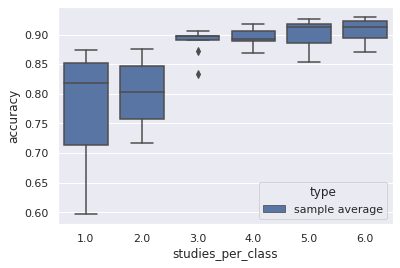

In [11]:
sns.boxplot(x='studies_per_class', y='accuracy', hue='type', data=res)


In [12]:
res = pd.DataFrame()

for j in range(3):

    for i in range(1,8):

        for h in range(3):
            model_name = 'mlp_s_s_inc_size_run_'+str(j)+'_step_'+str(i)+'_'+str(h)+'.h5'
            mlp_sra = tf.keras.models.load_model('models/'+model_name, compile=False)

            acc = utility.mlp_report(test, mlp_sra, 2, tissue_mapping)
            tmp_dic = {'name': model_name[:-5], 
                       'accuracy': acc[0],
                      'type': 'sample average',
                      'iter': j,
                      'studies_per_class': i}        
            res = res.append(tmp_dic, ignore_index=True)

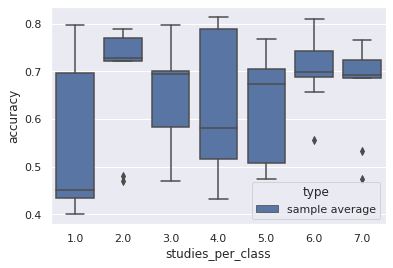

In [13]:
sns.boxplot(x='studies_per_class', y='accuracy', hue='type', data=res)
